# Gerando polígonos de vias por setor fiscal município de São Paulo

Esse notebook tem a intenção de ir um pouco além do último Notebook no sentido de avançar para um processamento viável para a publicação de uma nova camada no [Geosampa](http://geosampa.prefeitura.sp.gov.br/PaginasPublicas/_SBC.aspx) 

Para isso vamos utilizar as seguintes camadas, recortadas por um setor fiscal definido para testes

* [Logradouros](http://geosampa.prefeitura.sp.gov.br/PaginasPublicas/downloadIfr.aspx?orig=DownloadCamadas&arq=05_Sistema%20Vi%E1rio%5C%5CLogradouro%5C%5CShapefile%5C%5CSIRGAS_SHP_logradouronbl&arqTipo=Shapefile)
* [Quadras Fiscais](http://geosampa.prefeitura.sp.gov.br/PaginasPublicas/downloadIfr.aspx?orig=DownloadCamadas&arq=11_Cadastro%5C%5CQuadra%5C%5CShapefile%5C%5CSIRGAS_SHP_quadraMDSF&arqTipo=Shapefile)
* [Quadras Viárias](http://geosampa.prefeitura.sp.gov.br/PaginasPublicas/downloadIfr.aspx?orig=DownloadCamadas&arq=05_Sistema%20Vi%E1rio%5C%5CQuadra%20Viaria%5C%5CShapefile%5C%5CSIRGAS_SHP_quadraviariaed&arqTipo=Shapefile)

Para nossos primeiros experimentos vamos utilizar o setor fiscal de número 037:

* [Setores Fiscais](http://geosampa.prefeitura.sp.gov.br/PaginasPublicas/downloadIfr.aspx?orig=DownloadCamadas&arq=11_Cadastro%5C%5CSetor%5C%5CShapefile%5C%5CSIRGAS_SHP_setorfiscal&arqTipo=Shapefile)

Os arquivos baixados nos links acima devem ser descompactados e colocados na pas `gis` deste repositório para funcioarem de acordo com os scripts a seguir.


## Trabalhando com o Geopandas

O Geopandas é um projeto de código aberto escrito em Python, possui bastante maturidade, eficácia e performance para trabalhar com grandes quantidade de dados. Ele usa o Pandas, NumPy e Shapely para trabalhar com dados georeferenciados e portanto achamos oportuno usa-lo.

In [89]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (40, 30)

df_qf = gpd.read_file(f'gis/SIRGAS_SHP_quadraMDSF.shp')
df_qv = gpd.read_file(f'gis/SIRGAS_SHP_quadraviariaed_polygon.shp')
df_l = gpd.read_file(f'gis/SIRGAS_SHP_logradouronbl.shp')
df_s = gpd.read_file(f'gis/SIRGAS_SHP_setorfiscal.shp')
# df_s = gpd.read_file(f'gis/SIRGAS_SHP_prefeitura_regional_polygon.shp')

In [90]:
# df_s = df_s[df_s.sp_codigo == '12']
df_s = df_s[df_s.st_codigo == '037']

In [123]:
%time df_l = gpd.clip(df_l, df_s)

TypeError: 'gdf' should be GeoDataFrame or GeoSeries, got <class 'geopandas.sindex.SpatialIndex'>

In [92]:
%time df_vias = gpd.overlay(df_s, df_qv, how='difference')

CPU times: user 7.16 s, sys: 4 ms, total: 7.17 s
Wall time: 7.17 s


In [93]:
# %time df_qvias = gpd.clip(df_qv, df_s)

In [98]:
## TODO
# Crop nas linhas das vias para manter apenas as que estão dentro de df_vias
%time df_l_cropped = gpd.clip(df_l, df_vias)

CPU times: user 474 ms, sys: 0 ns, total: 474 ms
Wall time: 473 ms


In [99]:
df_l = df_l_cropped

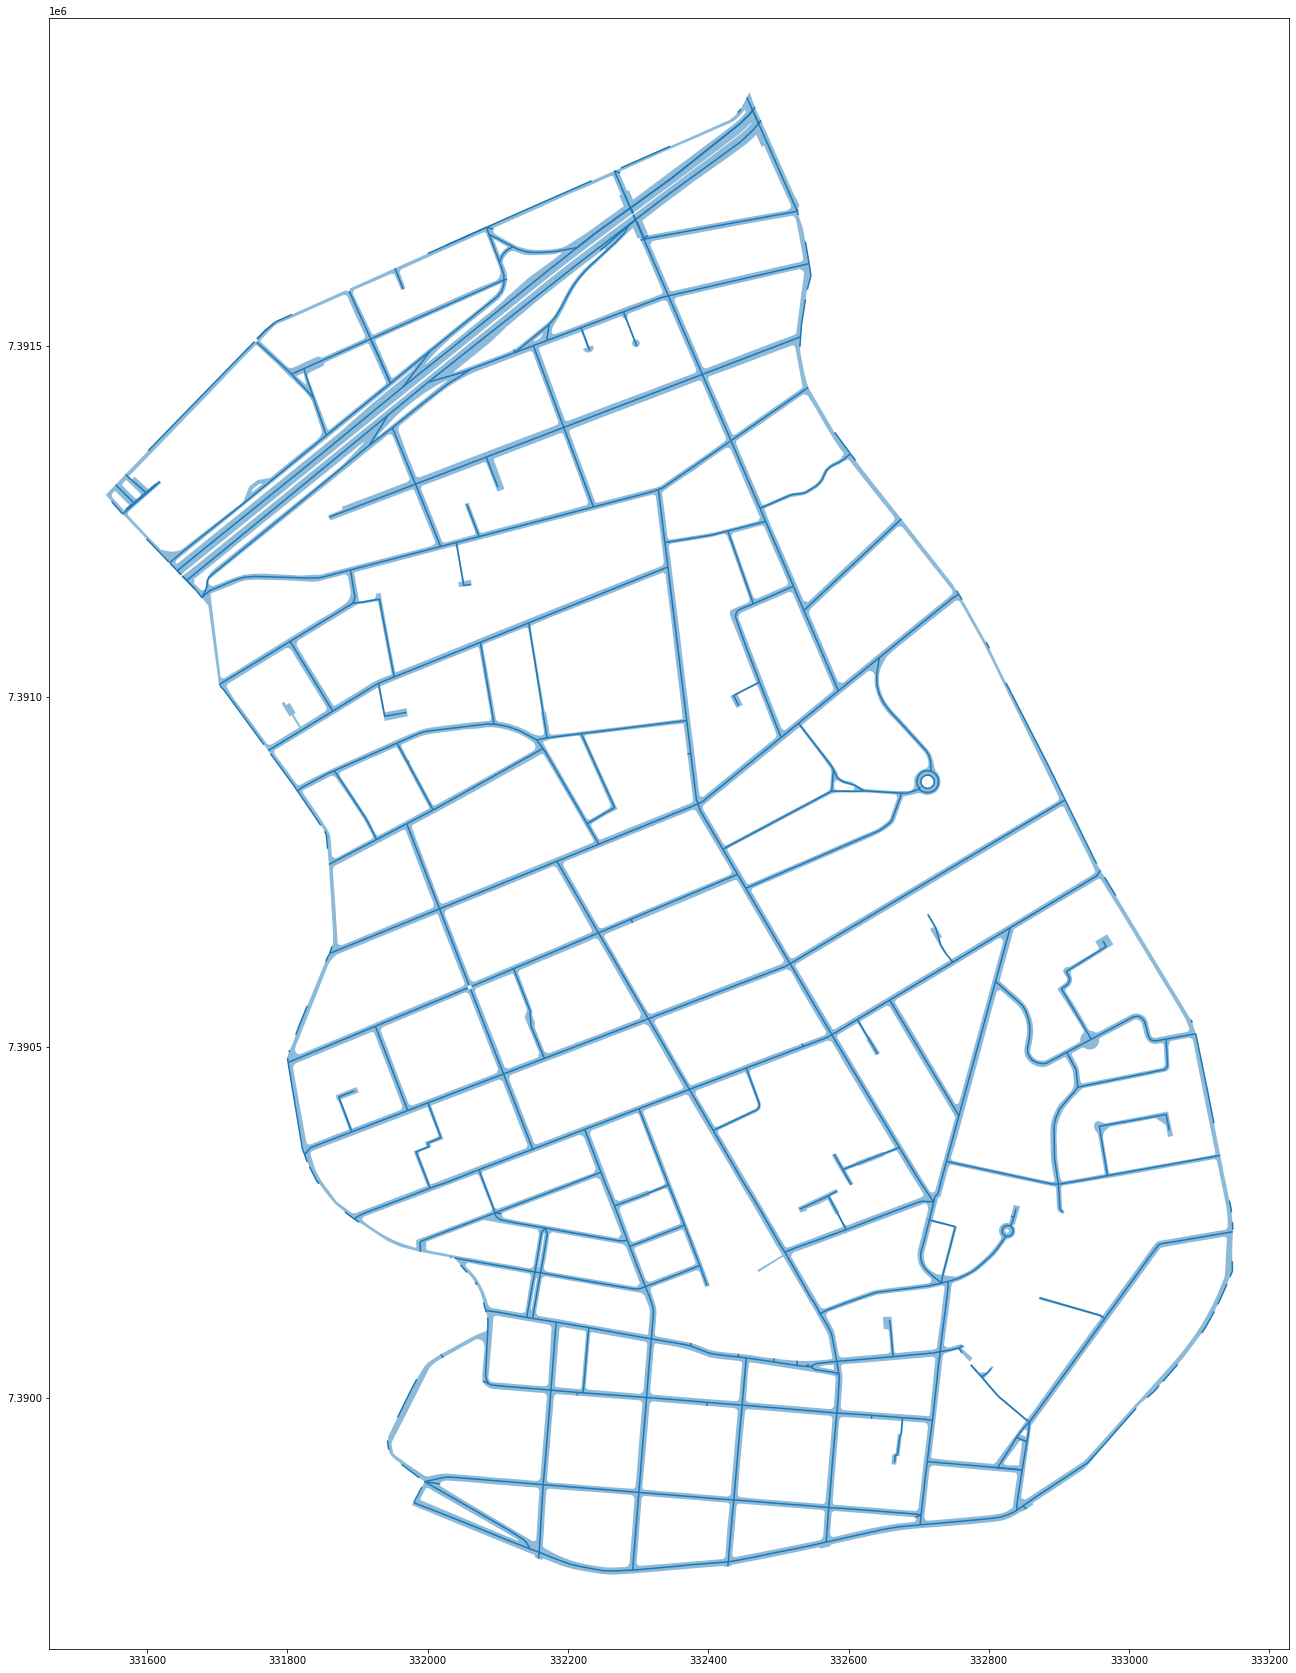

In [100]:
f, ax = plt.subplots(1)
df_vias.plot(ax=ax, alpha=0.5)
df_l.plot(ax=ax)
# df_logradouros.plot(ax=ax)

plt.show()

In [101]:
df_vias_buffered = df_vias.buffer(0.5)

Obtendo os pontos finais e iniciais de cada logradouro podemos saber onde as ruas começam e terminam

In [102]:
%time 
gdf_cruzamentos_inicio = df_l['geometry'].map(lambda x: (x.interpolate(0, normalized=True)))
gdf_cruzamentos_final = df_l['geometry'].map(lambda x: (x.interpolate(1, normalized=True)))
gdf_cruzamentos =  pd.concat([gdf_cruzamentos_inicio, gdf_cruzamentos_final])
gdf_c = gdf_cruzamentos

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


Como alguns pontos acabam ficando muito próximos, seria interessante agregar todos os pontos do cruzamento.

In [103]:
%time
cruzamentos = [p.centroid for p in gdf_c.buffer(5).unary_union]
df_cruzamentos = gpd.GeoDataFrame(geometry=cruzamentos)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


In [104]:
%time
df_pts = gpd.GeoDataFrame(geometry=df_cruzamentos.buffer(10).boundary.intersection(df_l.unary_union))
# filtrando somente os multipontos
df_cruzamentos = df_cruzamentos[df_pts.geometry.type == 'MultiPoint']
df_pts = df_pts[df_pts.geometry.type == 'MultiPoint']

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


In [105]:
# unir pontos e o ponto central do cruzamento
%time
df_cruzamentos['id'] = df_cruzamentos.index.values
df_pts['id'] = df_pts.index.values
df_pt_pts = df_cruzamentos.merge(df_pts, on='id', suffixes=('_cruzamento', '_pt'))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.29 µs


In [106]:
# Calcular o angulo para cada ponto de intersecção
# e calcular a mediatriz desse pontos
%time

import numpy as np

def calc_angulos(i):
    c_x, c_y = i.geometry_cruzamento.coords[0]
    coords = list(map(lambda x: x.coords[0], i.geometry_pt.geoms))
    p_x = np.array(list(map(lambda x: x[0], coords)))
    p_y = np.array(list(map(lambda x: x[1], coords)))
    delta_x, delta_y = [p_x - c_x, p_y - c_y]
    # Colocar os pontos em ordem de angulo
    angle = np.sort(np.arctan2(delta_x, delta_y) - 0.5 * np.pi)
    angle_normalized = angle / (np.pi * 2) + 0.75
    angle_plus = np.append(angle_normalized, 1 + angle_normalized[0:1])
    points = angle_normalized + (np.diff(angle_plus) / 2)
    points[-1] = points[-1] - 1
    return list(points)

angles = list(map(lambda x: calc_angulos(x), df_pt_pts.itertuples()))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.53 µs


In [107]:
%time
df_bounds = gpd.GeoDataFrame(geometry=df_cruzamentos.buffer(10).boundary)
df_bounds['angles'] = angles
# angles

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.29 µs


In [108]:
%time
from shapely.geometry import MultiPoint

inter_points = list(map(
    lambda x: MultiPoint(list(map(
        lambda y: x.geometry.interpolate(y - 0.75, normalized=True), 
#         lambda y: x.geometry.interpolate(0.85, normalized=True),
        x.angles))), 
    df_bounds.itertuples()))

df_inter_points = gpd.GeoDataFrame(geometry=inter_points)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.29 µs


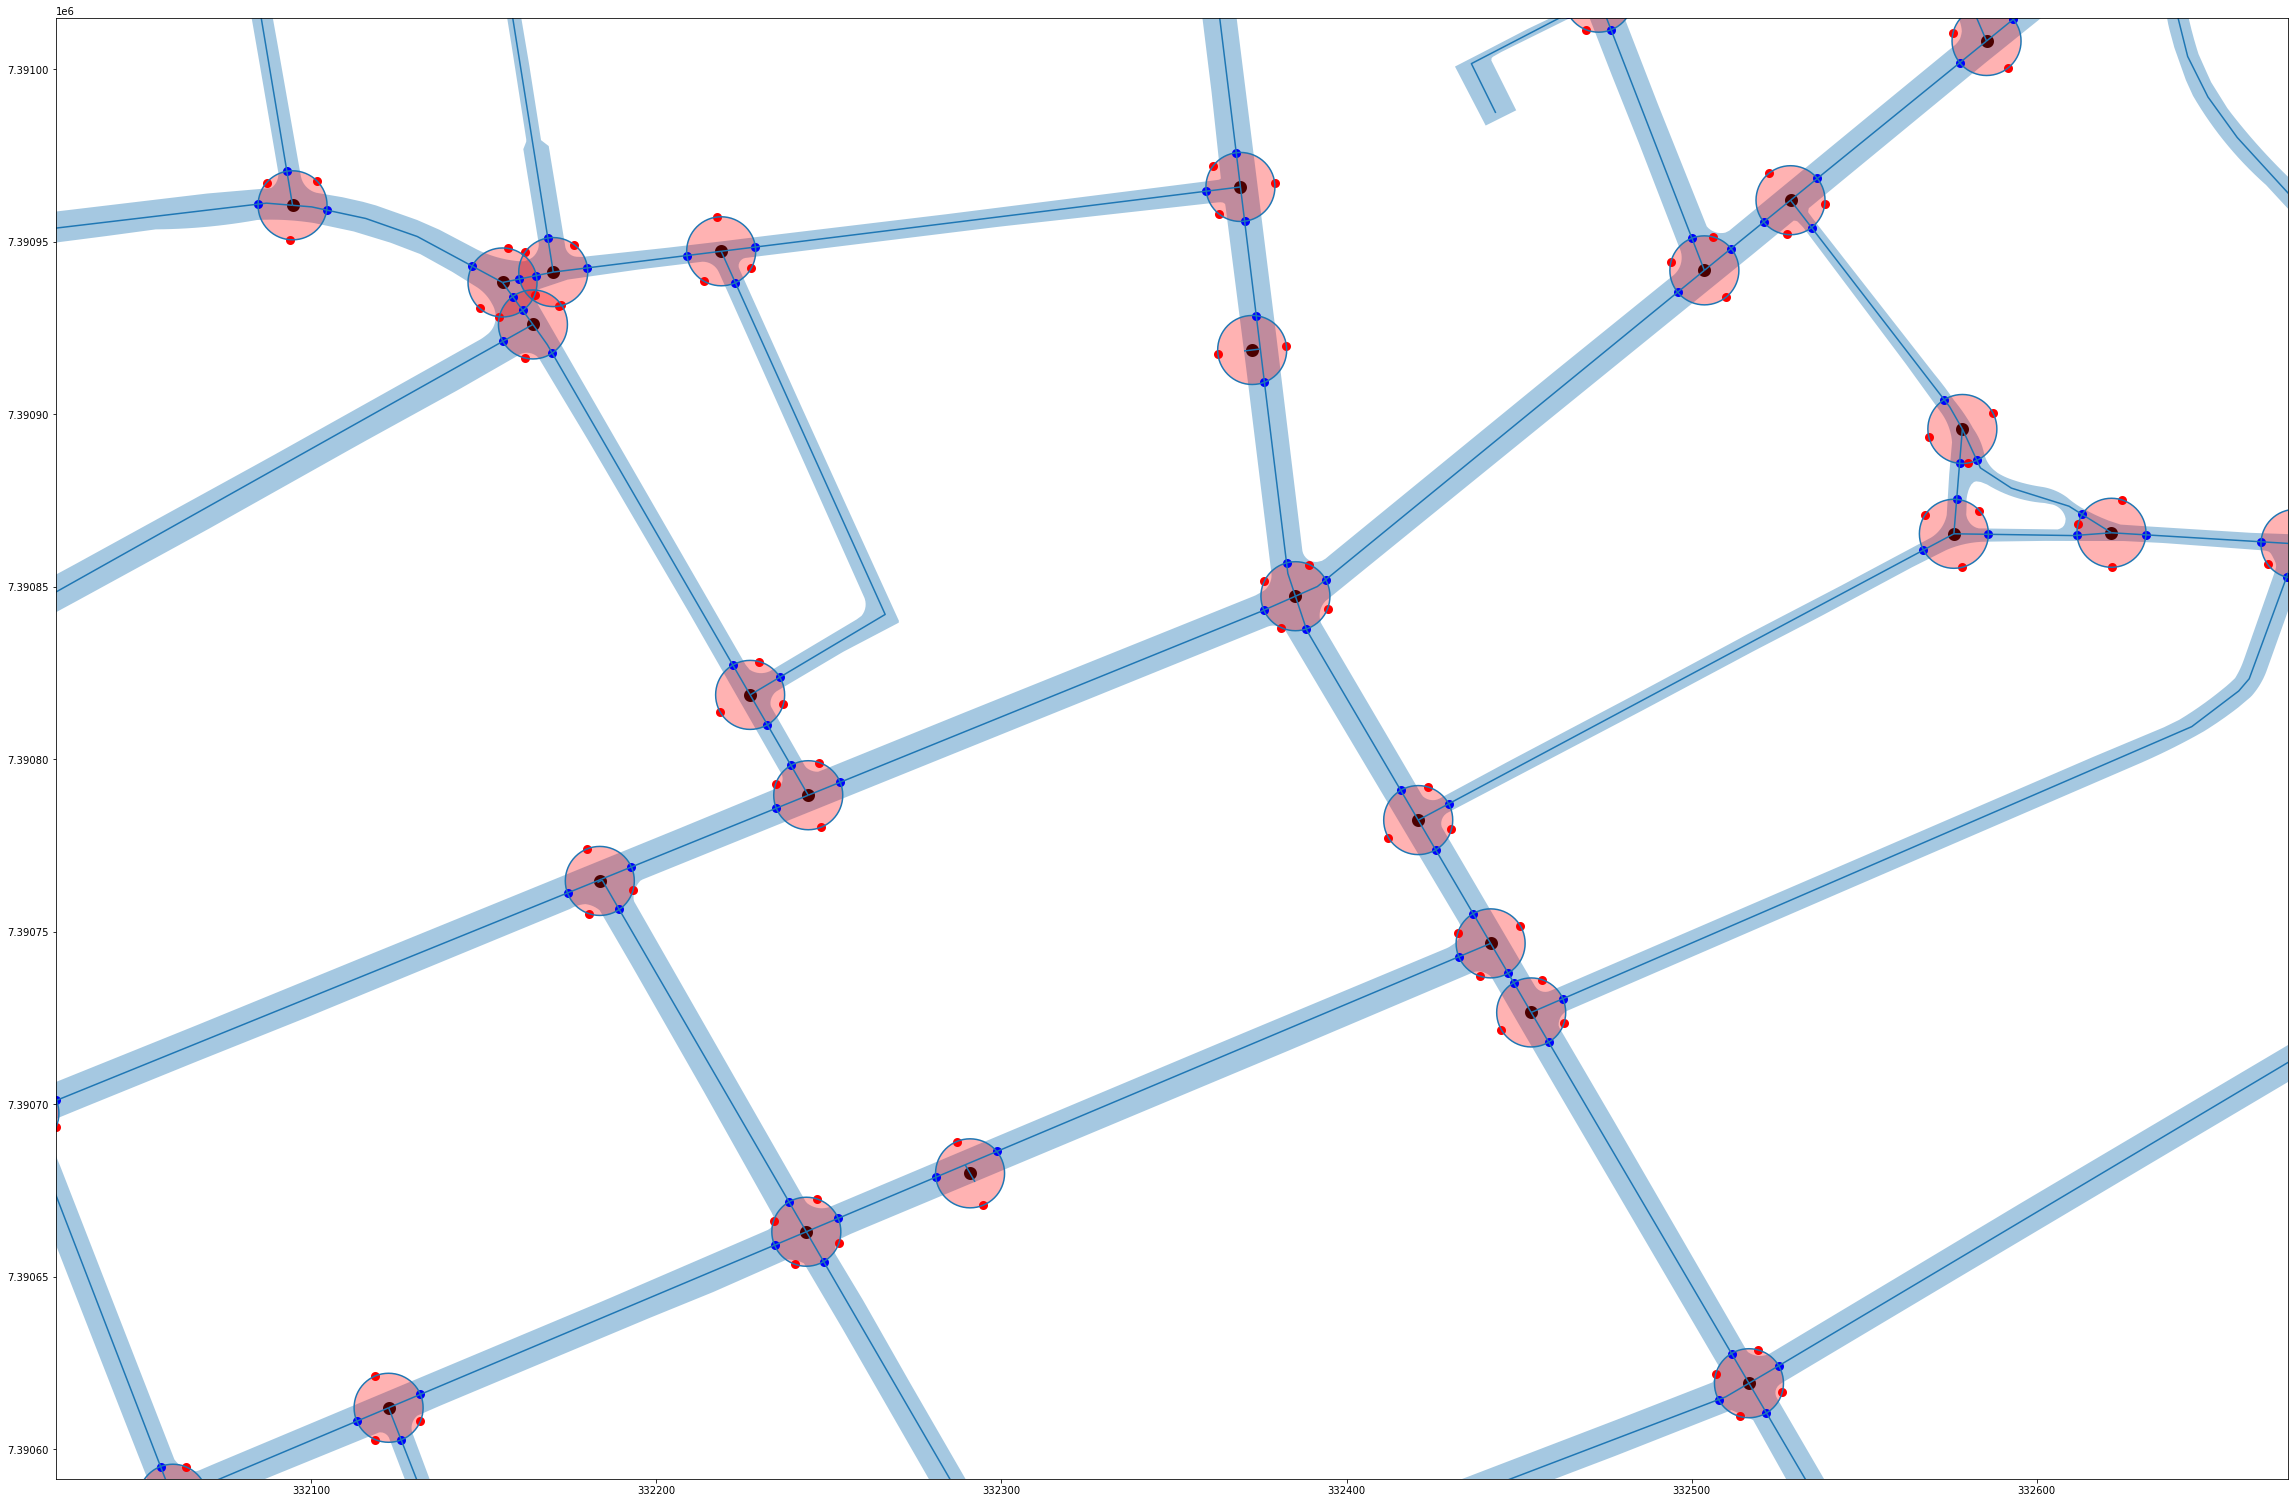

In [109]:
f, ax = plt.subplots(1)
df_vias.plot(ax=ax, alpha=0.4)
df_l.plot(ax=ax)
# df_cruz_buffer.plot(ax=ax, alpha=0.3, color='red')
df_cruzamentos.plot(ax=ax, lw=7, color='black')
df_cruzamentos.buffer(10).plot(ax=ax, alpha=0.3, color='red')
df_bounds.plot(ax=ax)
df_pts.plot(ax=ax, lw=3, color='blue')
df_inter_points.plot(ax=ax, lw=3, color='red')
# Aplicando o zoom
plt.margins(x=-0.30, y=-0.40)

plt.show()

## Criando linhas para 'cortar' os polígonos

Agora que temos que cortar o polígono precisamos de linhas para realizar esse fatiamento. 
Primeiramente vamos criar uma intersecção dos buffers dos nós com o traçado dos logradouros

In [110]:
%time
from shapely.geometry import MultiLineString, LineString
from shapely.affinity import scale

cut_lines = list(map(lambda x:
         scale(
             MultiLineString(list(map(lambda y: 
                  LineString([df_cruzamentos.geometry.iloc[x.Index], y]), 
                  x.geometry.geoms))),
             xfact = 2.0,
             yfact = 2.0,
             origin = df_cruzamentos.geometry.iloc[x.Index])
         , df_inter_points.itertuples()))

df_cut_lines = gpd.GeoDataFrame(geometry=cut_lines)
# df_cut_lines.plot()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


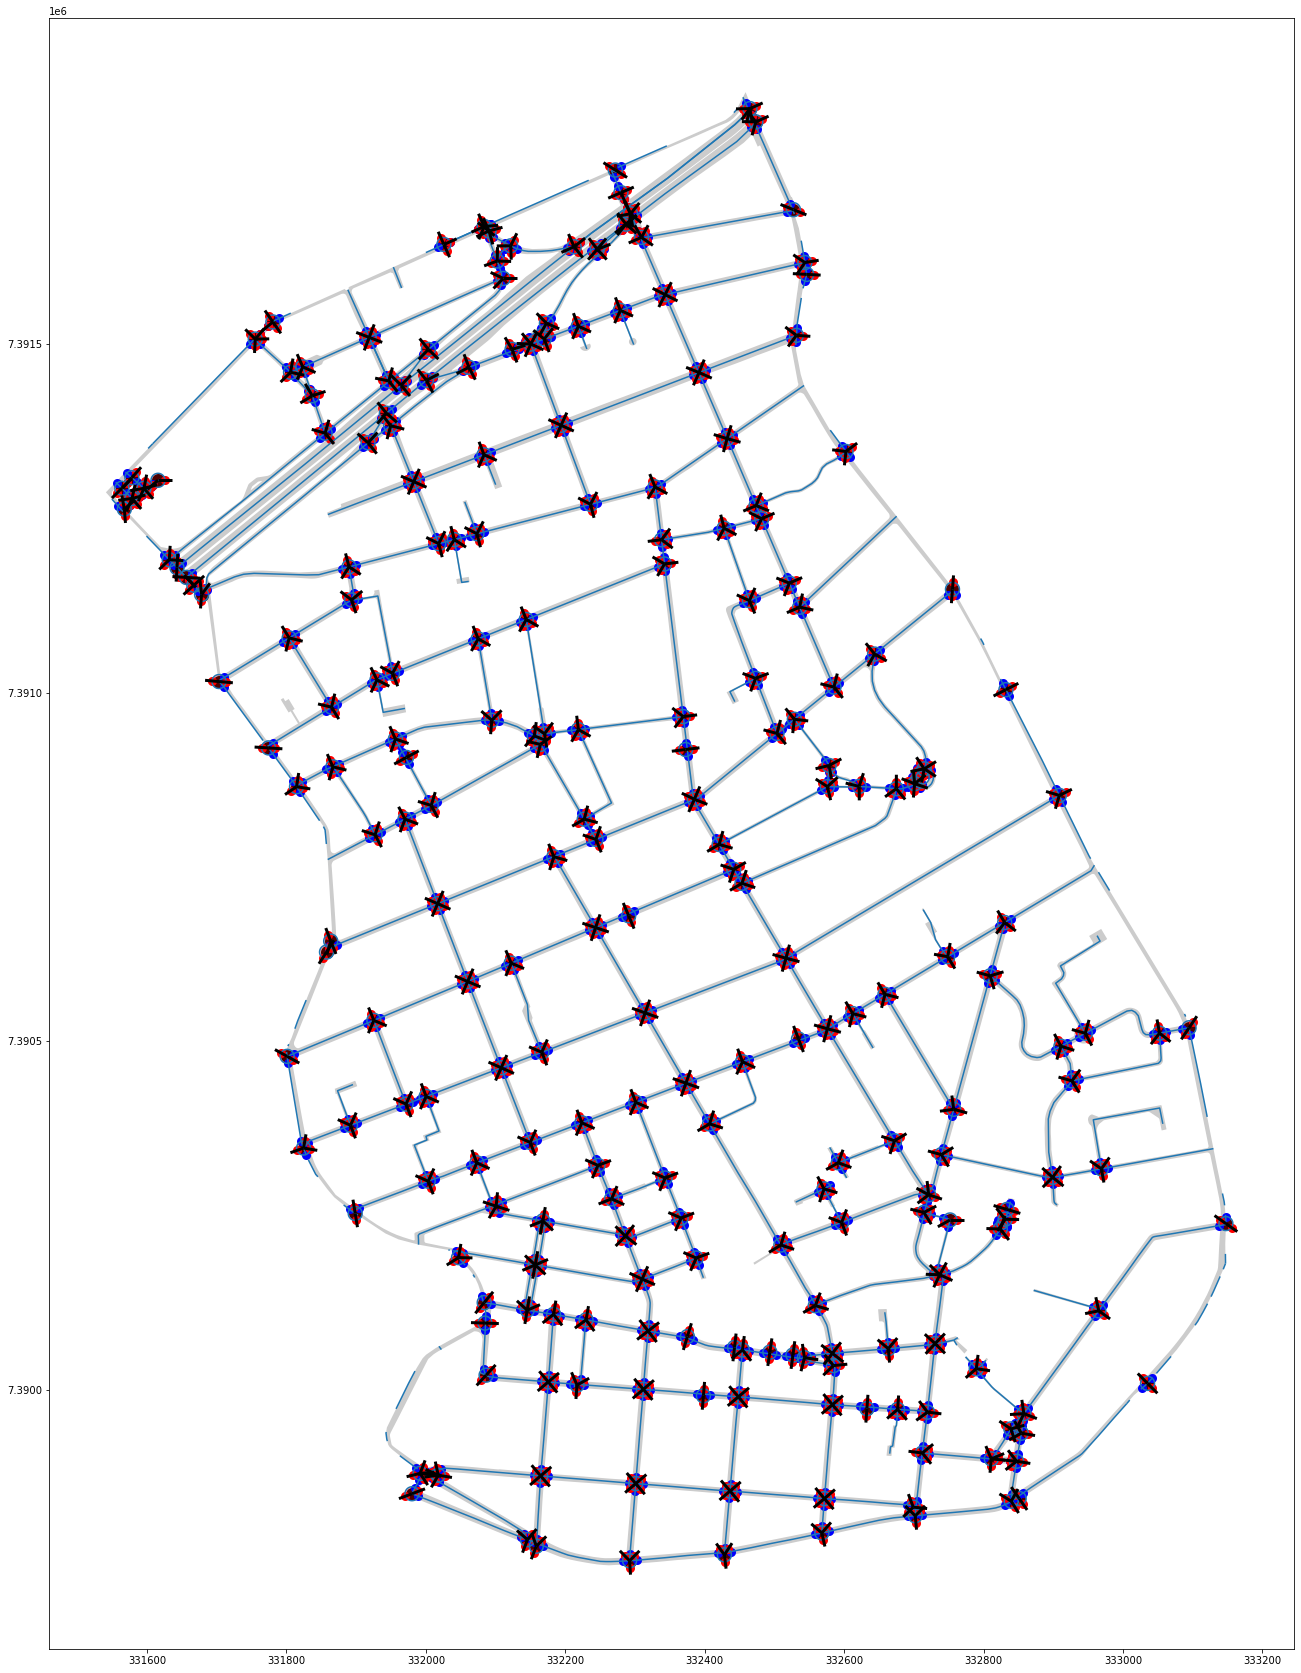

In [111]:
f, ax = plt.subplots(1)
df_vias.plot(ax=ax, alpha=0.4, color='grey')
df_l.plot(ax=ax)
# df_cruz_buffer.plot(ax=ax, alpha=0.3, color='red')
# df_vias_para_corte.plot(ax=ax, alpha=0.4, color='orange', linewidth=1, edgecolor='grey')
df_cruzamentos.plot(ax=ax, lw=7, color='black')
df_cruzamentos.buffer(10).plot(ax=ax, alpha=0.3, color='red')
df_bounds.plot(ax=ax)
df_pts.plot(ax=ax, lw=3, color='blue')
df_inter_points.plot(ax=ax, lw=3, color='red')
df_cut_lines.plot(ax=ax, lw=3, color='black')
# df_voronoi_polygon.plot(ax=ax, alpha=0.7, color='yellow', linewidth=1, edgecolor='grey')
# Aplicando o zoom
# plt.margins(x=-0.30, y=-0.40)


plt.show()

In [112]:
# lp = np.stack((df_l.geometry.interpolate(0.5, normalized=True).to_numpy, 
#                df_l.geometry.interpolate(0.001, normalized=True).to_numpy, 
#                df_l.geometry.interpolate(0.999, normalized=True).to_numpy))

lp = list(map(lambda x: MultiPoint([x.geometry.interpolate(0.5, normalized=True),
                             x.geometry.interpolate(0.001, normalized=True),
                             x.geometry.interpolate(0.999, normalized=True)]),
        df_l.itertuples()))

df_lp = gpd.GeoDataFrame(geometry=lp)
# df_lp


In [119]:
%time
from shapely.ops import cascaded_union, polygonize
df_vias_cutted = polygonize(cascaded_union([df_cut_lines.geometry.unary_union, list(df_vias.geometry.boundary)[0]]))
df_poligonos_de_vias = gpd.GeoDataFrame(geometry = list(df_vias_cutted))
df_pvias = df_poligonos_de_vias[df_poligonos_de_vias.geometry.crosses(df_lp.geometry.unary_union)]
# df_pvias = df_poligonos_de_vias[df_poligonos_de_vias.geometry.touches(df_l.geometry.unary_union)]

# df_pvias.plot(color = np.random.rand(len(df_poligonos_de_vias), 3))



CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.05 µs


In [120]:
df_pvias

,geometry
0,"POLYGON ((332292.232 7389754.655, 332285.830 7..."
1,"POLYGON ((332285.830 7389761.231, 332292.232 7..."
2,"POLYGON ((332292.232 7389754.655, 332299.517 7..."
3,"POLYGON ((332428.268 7389763.163, 332422.351 7..."
4,"POLYGON ((332428.268 7389763.163, 332435.425 7..."
...,...
480,"POLYGON ((332527.340 7391693.090, 332517.435 7..."
481,"POLYGON ((332473.402 7391819.055, 332468.048 7..."
483,"POLYGON ((332473.402 7391819.055, 332466.666 7..."
485,"POLYGON ((332463.345 7391831.604, 332461.666 7..."


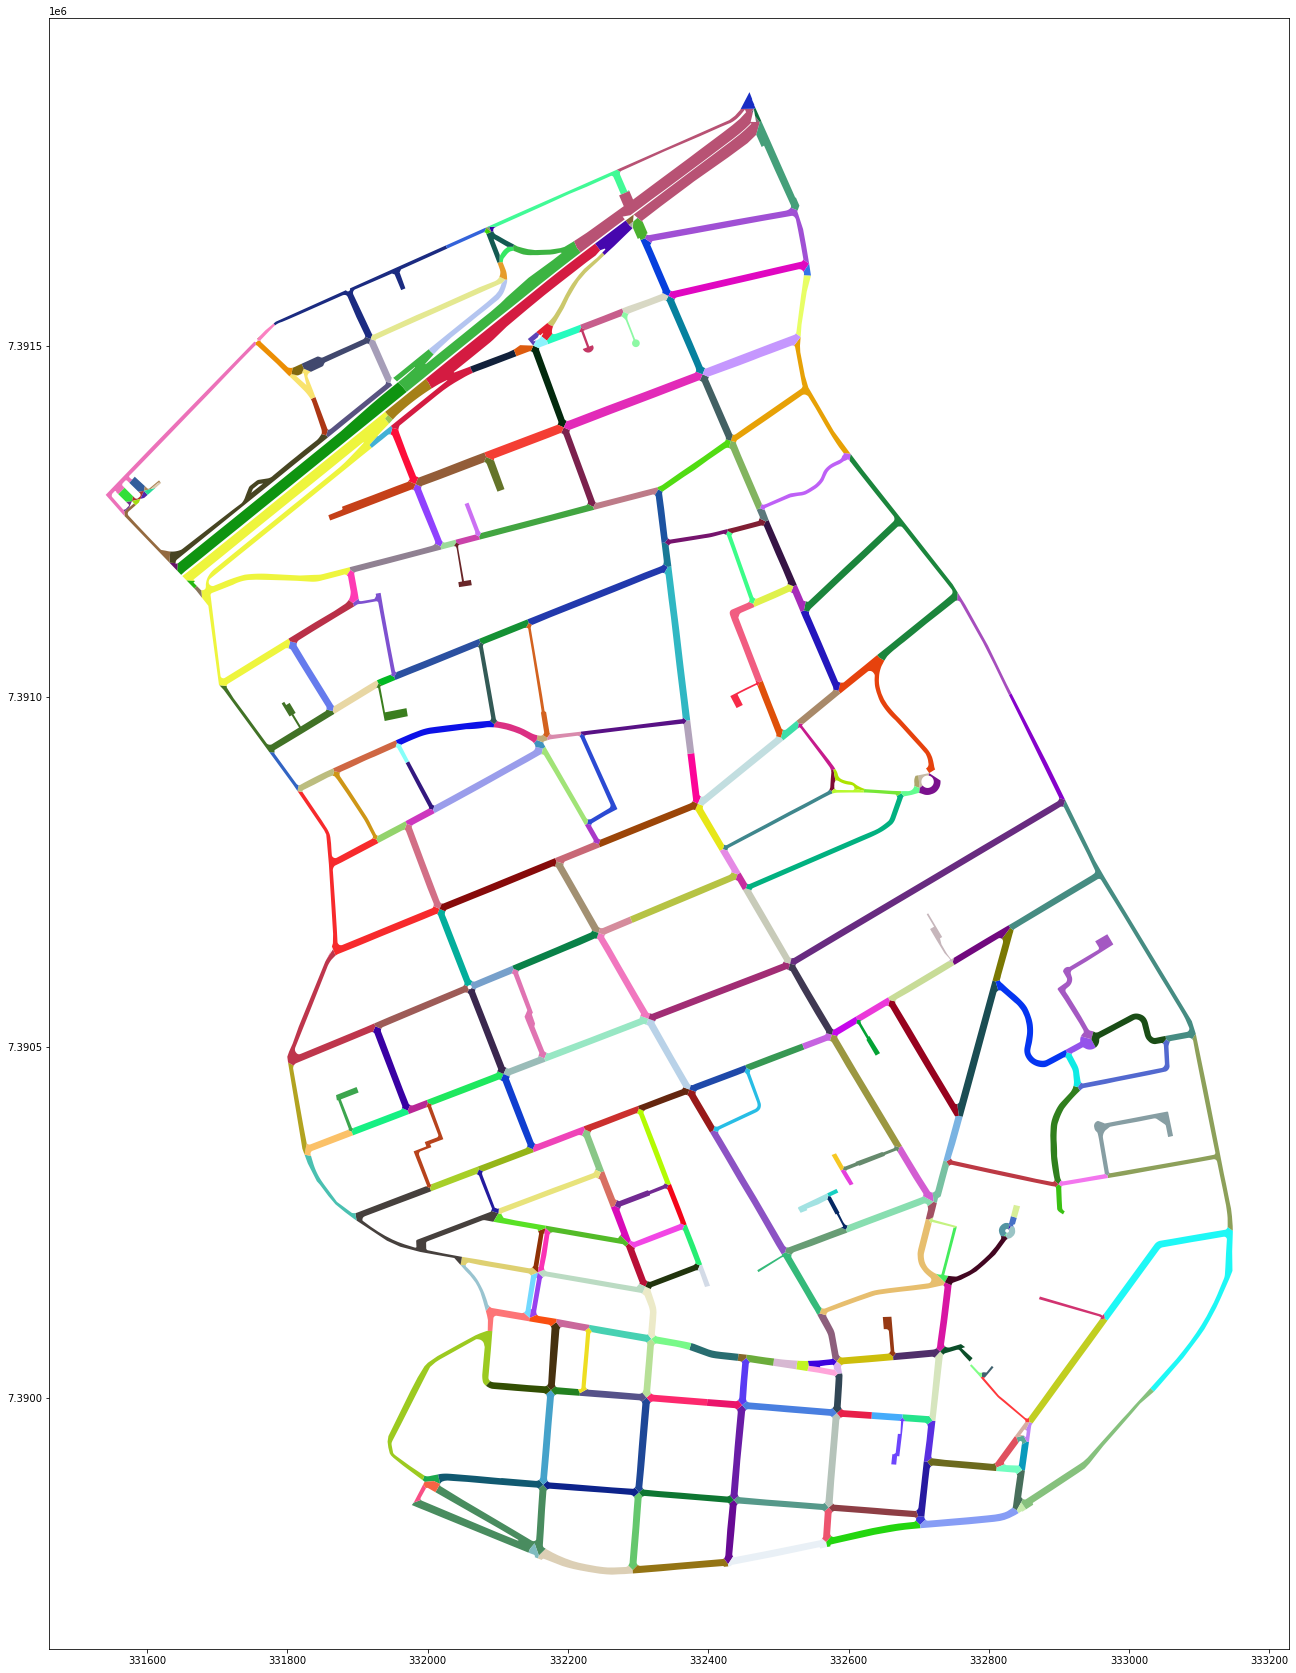

In [121]:
df_pvias.plot(color = np.random.rand(len(df_poligonos_de_vias), 3))

## Salvando o resultado

Agora que temos o polígono de cada via, podemos salvar o resultado para seguir com alguma outra análise como:
- Calcular a largura mínima máxima e média de cada via

In [122]:
df_pvias.to_file("poligono_de_vias.gpkg", layer='poligono_de_vias_vila_mariana', driver="GPKG")